In [0]:
# Holy Incantations
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Model
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input, concatenate
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.utils import np_utils
import keras.backend as K

In [0]:
# Keras provides the option to download the CIFAR10 dataset using its API
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
# CIFAR 10 dataset has 10 unique classes
num_classes = len(np.unique(train_labels))

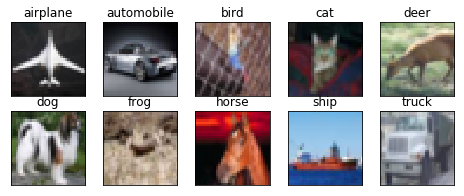

In [18]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

'''
We should always look at some sample of images before constructing any model
as it helps in determinig the size of final receptive field, placement of first
pool layer in the network.
'''
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
# normalising the training and test data
train_features = train_features.astype('float32')
test_features = test_features.astype('float32')
train_feature_mean = np.mean(train_features, axis=(0,1,2))
train_feature_std = np.std(train_features, axis=(0,1,2))
train_features_norm = (train_features-train_feature_mean)/train_feature_std
test_features_norm = (test_features-train_feature_mean)/train_feature_std

In [0]:
def conv(features, filters, kernel=(3,3), activation='relu', padding='same', dilation=1):
  convolution = Conv2D(filters, kernel, padding=padding, dilation_rate=dilation)(features)
  bn = BatchNormalization()(convolution)
  relu = Activation('relu')(bn)
  return relu

In [0]:
# Define the model
model_input = Input(shape=(32,32,3))

# normal convolution 
layer1 = conv(model_input, 32, kernel=(3, 3), padding='same') # rf: 3, os: 32x32
layer1 = Dropout(0.1)(layer1)

# spatially separable convolution
layer2 = Conv2D(32, (1,3), padding='same')(layer1)
layer2 = Conv2D(64, (3,1), padding='same')(layer2)# rf: 5, os: 32x32
layer2 = Dropout(0.1)(layer2)

# grouped convolution (one with dilation=1 and other one with dilation=2)
layer3_1 = conv(layer2, 128, (3, 3), dilation=1, padding='same')
layer3_2 = conv(layer2, 128, (3, 3), dilation=2, padding='same') # rf: 7, 9, os: 32x32
layer3 = concatenate([layer3_1, layer3_2], axis=-1)

# max pool layer
MP1 = MaxPooling2D(pool_size=(2,2))(layer3) # rf: 8, 10, os: 16x16

#n normal 1x1 convolution
layer4= conv(MP1, 32, (1,1))# rf: 8, 10, os: 16x16
layer4 = Dropout(0.1)(layer4)

# grouped convolution (one branch with a kernel of 3x3 and other with  a filter of 5x5)
layer5_1 = conv(layer4, 64, (3, 3), padding='same') 
layer5_2 = conv(layer4, 64, (5, 5), padding='same')
layer5 = concatenate([layer5_1, layer5_2], axis=-1) # rf: 12, 18, os: 16x16
layer5 = Dropout(0.1)(layer5)

# depthwise separable convolution
layer6 = SeparableConv2D(256, 3, padding='valid')(layer5) # rf: 16, 22, os: 14x14
layer6 = BatchNormalization()(layer6)
layer6 = Activation('relu')(layer6)

#max pool layer
MP2 = MaxPooling2D(pool_size=(2, 2))(layer6)# rf: 18, 24, os:7x7 

layer7 = conv(MP2, 32, (1,1), padding='same')# rf: 18, 24, os:7x7

# normal  convolution
layer8 = conv(layer7, 10, (7,7), activation=None, padding='valid')# rf: 42, 48, os:1x1
layer8 = Flatten()(layer8)

output = Activation('softmax')(layer8)

model = Model(inputs=model_input, outputs=output)

In [36]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 32, 32, 32)   896         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 32, 32, 32)   128         conv2d_27[0][0]                  
__________________________________________________________________________________________________
activation_25 (Activation)      (None, 32, 32, 32)   0           batch_normalization_23[0][0]     
____________________________________________________________________________________________

In [0]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# using learning rate scheduler to decrease the learning gradulally as the 
# number of epochs increases
def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * np.exp(0.1 * (10 - epoch))

lr_scheduler = LearningRateScheduler(scheduler)

# modelcheckpoint = ModelCheckpoint()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=390.625, validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., epochs=50)`
  app.launch_new_instance()


Epoch 1/50
391/390 [==============================] - 79s 201ms/step - loss: 1.6809 - acc: 0.4279 - val_loss: 1.5421 - val_acc: 0.4868
Epoch 2/50
391/390 [==============================] - 71s 183ms/step - loss: 1.3161 - acc: 0.5645 - val_loss: 1.2302 - val_acc: 0.5963
Epoch 3/50
391/390 [==============================] - 71s 183ms/step - loss: 1.1415 - acc: 0.6196 - val_loss: 1.2666 - val_acc: 0.6038
Epoch 4/50
391/390 [==============================] - 71s 182ms/step - loss: 1.0143 - acc: 0.6638 - val_loss: 0.8409 - val_acc: 0.7164
Epoch 5/50
391/390 [==============================] - 71s 182ms/step - loss: 0.9416 - acc: 0.6878 - val_loss: 0.8306 - val_acc: 0.7277
Epoch 6/50
391/390 [==============================] - 72s 183ms/step - loss: 0.8835 - acc: 0.7052 - val_loss: 0.8543 - val_acc: 0.7160
Epoch 7/50
391/390 [==============================] - 71s 182ms/step - loss: 0.8263 - acc: 0.7242 - val_loss: 0.7445 - val_acc: 0.7586
Epoch 8/50
391/390 [==============================] - 7

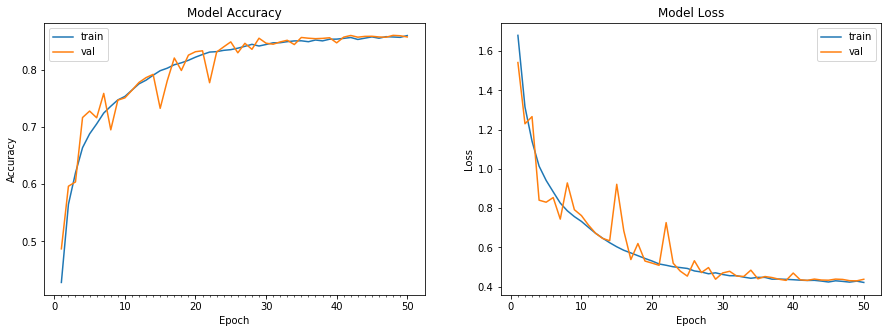

Accuracy on test data is: 18.05


In [38]:
from keras.preprocessing.image import ImageDataGenerator

# Using data augmentation techniques to generalise the model further 
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True)

datagen.fit(train_features)

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features_norm, train_labels, batch_size = 128),
                                 steps_per_epoch = train_features.shape[0]/128, nb_epoch = 50, 
                                 validation_data = (test_features_norm, test_labels), 
                                 verbose=1, callbacks=[lr_scheduler])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Performance of this model is very similar to the improved model in Assignment 6A. 